# Problem 2

In [22]:
using Plots, DelimitedFiles
flatten(x) = [x[i] for i in eachindex(x)];

In [23]:
X, y = readdlm("moons.x.csv", ','), flatten(readdlm("moons.y.csv"))
n = size(X, 1)
thresh = Int(4*n/5)
X, y, X_test, y_test = X[1:thresh, :], y[1:thresh], X[thresh+1:end, :], y[thresh+1:end]
n, d = size(X);

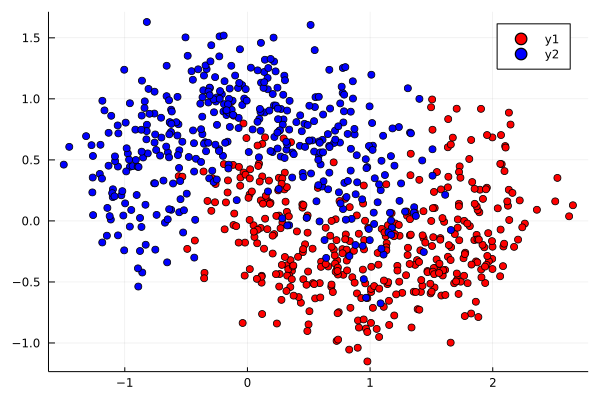

In [24]:
X_plus, X_minus = X[y .== 1, :], X[y .== -1, :]
fig1 = scatter(X_plus[:, 1], X_plus[:, 2], c=:red, leg=false)
fig1 = scatter!(X_minus[:, 1], X_minus[:, 2], c=:blue)

In [25]:
function decisionstump(p̄, X̄, ȳ)
    n, d = size(X̄)
    length(p̄) !== n && 
        throw(DimensionMismatch("length of distribution does not match number of examples"))
    Xyp = hcat(X̄, ȳ, p̄)
    # allows for in-place sorting of X, y, p simultaneously
    X, y, p = [], [], []
    Err, Errs = 0., []
    # Errs will be compared to choose best j, s

    for j in 1:d
        Xyp = sortslices(Xyp, dims=1, by=row -> row[j], rev=true)
        # sort rows so elements of column j are in descending order, O(nlog(n))
        X, y, p = Xyp[:, 1:end-2], Xyp[:, end-1], Xyp[:, end]

        Err = sum(p[i] for i in 1:n if y[i] * (X[i, j] - X[1, j]) ≤ 0)
        # could be optimized to reduce flops
        push!(Errs, (j, X[1, j], Err))
        for i in 2:n
            y[i-1] * (X[i-1, j] - X[i, j]) ≤ 0 && (Err += p[i-1])
            y[i] * (X[i, j] - X[i-1, j]) ≤ 0 && (Err -= p[i])
            # sum only changes when s = X[i, j], 
            # once s = X[i, j], only the terms p[i-1] and p[i] can change,
            # edit the sum incementally, O(n)
            push!(Errs, (j, X[i, j], Err))
        end
    end # total flops O(n^2 d log(n)), slowed down by sorting

    if minimum(getindex.(Errs, 3)) > minimum(1 .- getindex.(Errs, 3))
    # test if x -> -sign(x[j] - s) is more accurate
        Err = Errs[argmin(1 .- getindex.(Errs, 3))]
        return (Err[1], Err[2], x -> -sign(x[Err[1]] - Err[2]))
    else 
        Err = Errs[argmin(getindex.(Errs, 3))]
        return (Err[1], Err[2], x -> sign(x[Err[1]] - Err[2]))
    end
end;

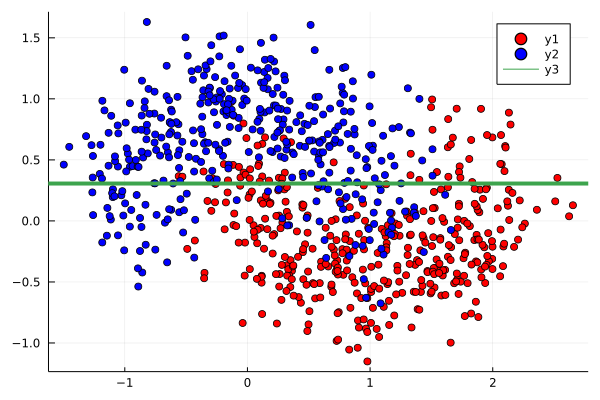

In [26]:
dim, thresh, phi = decisionstump(ones(n)./n, X, y)
dim == 1 && vline!([thresh], linewidth=4)
dim == 2 && hline!([thresh], linewidth=4)

In [27]:
function Adaboost(X, y; nditer=4)
    n = size(X, 1)
    theta, w, phi = [], [], []
    # initialize

    push!(phi, decisionstump(ones(n)./n, X, y)[3])
    W_plus = sum(1/n for i in 1:n if y[i] * phi[1](X[i, :]) == 1)
    W_minus = sum(1/n for i in 1:n if y[i] * phi[1](X[i, :]) == -1)
    push!(theta, 0.5 * log(W_plus / W_minus))
    nditer == 1 && (return phi)

    for t in 2:nditer
        w = exp.(-y[i] * sum(theta[j] * phi[j](X[i, :]) for j in 1:t-1) for i in 1:n)
        # calculates weights using exp(-yⁱ θ'Φ)
        push!(phi, decisionstump(w./sum(w), X, y)[3])
        # use decisionstump to generate a weak learner

        W_plus = sum(w[i] for i in 1:n if y[i] * phi[t](X[i, :]) == 1)
        W_minus = sum(w[i] for i in 1:n if y[i] * phi[t](X[i, :]) == -1)
        push!(theta, 0.5 * log(W_plus / W_minus))
        # calculate new θ, could be optimized here
    end

    return x -> sign(theta' * [phi[j](x) for j in 1:nditer])
end;

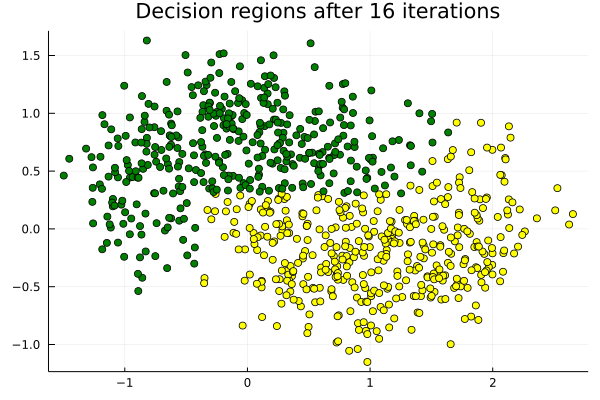

In [28]:
phi = Adaboost(X, y; nditer=16)
phi = phi.(collect(eachrow(X)))

X_phi_plus, X_phi_minus = X[phi .== 1, :], X[phi .== -1, :]
fig2 = scatter(X_phi_plus[:, 1], X_phi_plus[:, 2], 
               title="Decision regions for 16 iterations", 
               c=:yellow, leg=false)
fig2 = scatter!(X_phi_minus[:, 1], X_phi_minus[:, 2], c=:green)

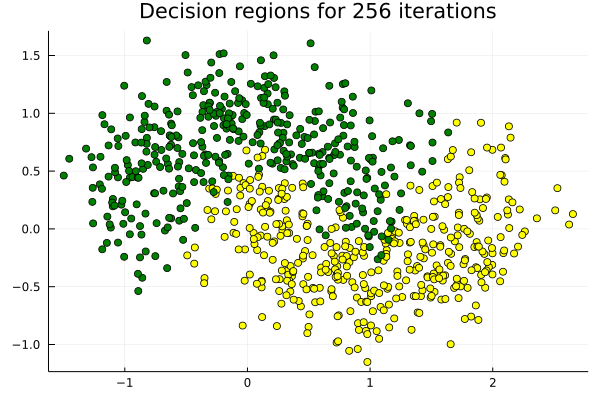

In [29]:
phi = Adaboost(X, y; nditer=256)
phi = phi.(collect(eachrow(X)))

X_phi_plus, X_phi_minus = X[phi .== 1, :], X[phi .== -1, :]
fig2 = scatter(X_phi_plus[:, 1], X_phi_plus[:, 2], 
               title="Decision regions for 256 iterations", 
               c=:yellow, leg=false)
fig2 = scatter!(X_phi_minus[:, 1], X_phi_minus[:, 2], c=:green)

In [30]:
phi = [Adaboost(X, y; nditer=i) for i in 2:4:128]
phi_train = [phiⱼ.(collect(eachrow(X))) for phiⱼ in phi]
phi_test = [phiⱼ.(collect(eachrow(X_test))) for phiⱼ in phi]

phi_train = [sum(abs.(phiⱼ .- y)) for phiⱼ in phi_train]
phi_test = [sum(abs.(phiⱼ .- y_test)) for phiⱼ in phi_test];

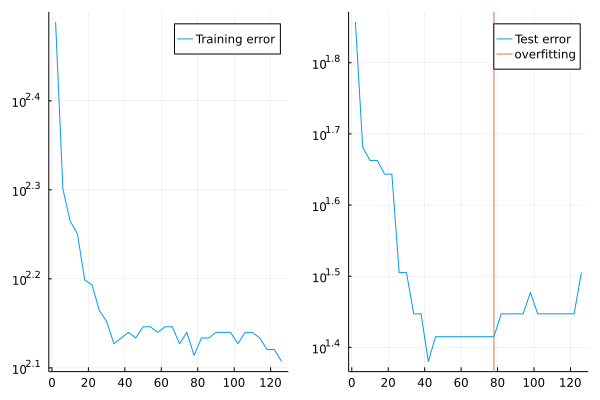

In [31]:
fig1 = plot(2:4:128, phi_train, lab="Training error", yscale=:log10)
fig2 = plot(2:4:128, phi_test, lab="Test error", yscale=:log10)
fig2 = vline!([78], lab="overfitting")
fig = plot(fig1, fig2, layout=2)